In [44]:
import numpy as np
import qutip as qutip
import time as time

from matplotlib import pyplot as plt

import sys
import os
sys.path.append('../../utils')

from tomography import coherent_state_tomography as cst
from tomography import coherent_state_tomography_copy as cst2
from visualization import state_visualization as state_vis
from quantum_utils import quantum_optics_utils as qou

from mpl_toolkits.mplot3d.axes3d import Axes3D
from math_utils import statistics_utils as su

from scipy import special

In [5]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>


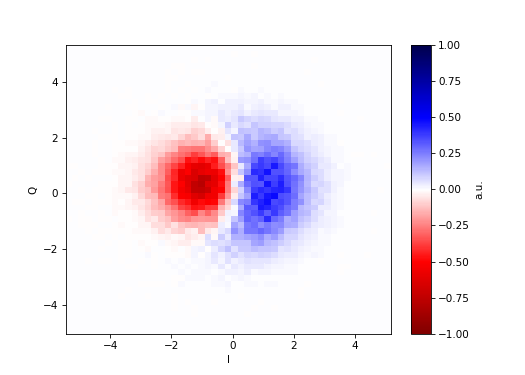

In [6]:
# 1.5 pi pulse data
pi = np.pi
scale = 1

path = "/Users/andreas/Desktop/work/cluster_state/photon_tomography/measurement_data/"
f_real = open(os.path.join(path, 'Q3_278.22mV_field_singleshot_1.5pi_5times_real.txt'))
f_imag = open(os.path.join(path, 'Q3_278.22mV_field_singleshot_1.5pi_5times_imag.txt'))
data_real = f_real.readlines()
data_imag = f_imag.readlines()
data_real_all = np.array( [np.array([float(val) for val in data_real[i].split('\t')]) for i in range(4,9)]).flatten()
data_imag_all = np.array( [np.array([float(val) for val in data_imag[i].split('\t')]) for i in range(4,9)]).flatten()
shots_all_p1 = (data_real_all + 1j*data_imag_all)
shots_all_p1 = scale * shots_all_p1
f_real.close(); f_imag.close()

f_real = open(os.path.join(path, 'Q3_278.22mV_field_singleshot_1.5pi_5times_real_dark.txt'))
f_imag = open(os.path.join(path, 'Q3_278.22mV_field_singleshot_1.5pi_5times_imag_dark.txt'))
data_real = f_real.readlines()
data_imag = f_imag.readlines()
data_real_all = np.array( [np.array([float(val) for val in data_real[i].split('\t')]) for i in range(4,9)]).flatten()
data_imag_all = np.array( [np.array([float(val) for val in data_imag[i].split('\t')]) for i in range(4,9)]).flatten()
shots_all_dark = (data_real_all + 1j*data_imag_all)
shots_all_dark = scale * shots_all_dark
f_real.close(); f_imag.close()

hist_2D_p1 = np.histogram2d(np.real(shots_all_p1), np.imag(shots_all_p1), bins = 50, density = True)
hist_2D_dark = np.histogram2d(np.real(shots_all_dark), np.imag(shots_all_dark), 
                                 range = [[hist_2D_p1[1][0], hist_2D_p1[1][-1]], [hist_2D_p1[2][0], hist_2D_p1[2][-1]]],
                                 bins = 50, density = True)
dI_dQ = (hist_2D_p1[1][0] - hist_2D_p1[1][-1])*(hist_2D_p1[2][0] - hist_2D_p1[2][-1])/2500

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1)
yy, xx = np.meshgrid(hist_2D_p1[1][:-1], hist_2D_p1[2][:-1])
pcolor = ax.pcolormesh(xx, yy, (hist_2D_p1[0] - hist_2D_dark[0])/dI_dQ, cmap='seismic_r')
fig.colorbar(pcolor, ax=ax, aspect = 15, label = "a.u.")
ax.set_xlabel('I'); ax.set_ylabel('Q') 
pcolor.set_clim(-1,1)

In [8]:
# Check if the scaling is already taken care of

# <a>
a_avg_abs = np.abs(np.mean(shots_all_p1))
print(np.abs(a_avg_abs))

# <a_dag_a>
a_dag_a = np.mean(np.abs(shots_all_p1)**2) - np.mean(np.abs(shots_all_dark)**2)
print(a_dag_a)

# sqrt(G_eta)
sqrt_G = a_dag_a / a_avg_abs
G = sqrt_G**2
print(G)

0.3276817413137409
0.33325307882460375
1.0342936424547473


In [9]:
# Construct the scaled data
scaled_shots_all_dark = shots_all_dark / sqrt_G
scaled_shots_all_p1 = shots_all_p1 / sqrt_G

In [10]:
# Construct the ideal POVM for the noise reconstruction
max_x = 7.5
mesh_size = 0.5

# Define the range of dimensions
dim = 100

s = time.time()
ideal_povm, alphas, xs, ps = cst2.generate_coherent_state_POVM(max_x, 
                                                              mesh_size, 
                                                              dim,
                                                              cutoff=0)
e = time.time()
print('Constructing POVM took: ' + str(e - s) + str(' seconds'))

Constructing POVM took: 11.920231819152832 seconds


In [11]:
# Make the scaled histograms
hist_2D_dark = np.histogram2d(np.real(shots_all_dark), np.imag(shots_all_dark), 
                                 range = [[xs[0] - mesh_size/2, xs[-1] + mesh_size/2],[ps[0] - mesh_size/2, ps[-1] + mesh_size/2]],
                                 bins = len(xs), density = True)[0]

hist_2D = np.histogram2d(np.real(shots_all_p1), np.imag(shots_all_p1), 
                                 range = [[xs[0] - mesh_size/2, xs[-1] + mesh_size/2],[ps[0] - mesh_size/2, ps[-1] + mesh_size/2]],
                                 bins = len(xs), density = True)[0]

In [12]:
# Do the noise state MLE
# Perform ideal coherent state POVM MLE
number_of_mle_iterations = 300
s = time.time()
reconstructed_noise_state, noise_lls = \
    cst2.perform_coherent_state_MLE(
        ideal_povm,
        hist_2D_dark, 
        number_of_mle_iterations,
        frequency_threshold=0,
        cutoff=0,
        identity_mixin=0)
e = time.time()
print('Time for MLE reconstruction for dim = ' + str(dim) + ': ' + str(e - s) + ' s')
# HERE

Time for MLE reconstruction for dim = 100: 324.88322377204895 s


In [13]:
# Fit the noise state to get the noise photons
number_of_noise_photons = 1.37
ideal_noise_state = qutip.thermal_dm(dim, number_of_noise_photons)
ideal_noisy_qfunc = qutip.qfunc(ideal_noise_state, xs, ps, g=2)
reconstructed_noisy_qfunc = qutip.qfunc(reconstructed_noise_state, xs, ps, g=2)

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(xs, reconstructed_noisy_qfunc[len(xs) // 2], label='Reconstructed Dark State (300 MLE iterations)')
ax.plot(xs, ideal_noisy_qfunc[len(xs) // 2], label='Thermal state')
ax.set_xlabel('X')
ax.set_ylabel('Q')
ax.legend()
ax.set_title('Q Function: P=0 Cross-section')

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Q Function: P=0 Cross-section')

In [14]:
# Make the noisy POVM
# Construct the ideal POVM for the noise reconstruction
max_x = 7.5
mesh_size = 0.5

# Define the dimension
dim = 300
fit_number_of_noise_photons = 1.37
high_dimensional_ideal_noise_state = qutip.thermal_dm(dim, fit_number_of_noise_photons)

s = time.time()
ideal_povm, alphas, xs, ps = cst2.generate_coherent_state_POVM(max_x, 
                                                              mesh_size, 
                                                              dim,
                                                              noise_base = high_dimensional_ideal_noise_state,
                                                              cutoff=0)
e = time.time()
print('Constructing POVM took: ' + str(e - s) + str(' seconds'))

Constructing POVM took: 265.11210894584656 seconds


In [24]:
# Pending 24000 + 12000

# Do the signal state MLE
# Perform ideal coherent state POVM MLE
number_of_mle_iterations = 24000
s = time.time()
reconstructed_signal_state, signal_lls = \
    cst2.perform_coherent_state_MLE(
        ideal_povm,
        hist_2D, 
        number_of_mle_iterations,
        frequency_threshold=0,
        cutoff=0,
        rho0=reconstructed_signal_state,
        identity_mixin=0)
e = time.time()
print('Time for MLE reconstruction for dim = ' + str(dim) + ': ' + str(e - s) + ' s')

Time for MLE reconstruction for dim = 300: 21456.911358118057 s


<IPython.core.display.Javascript object>


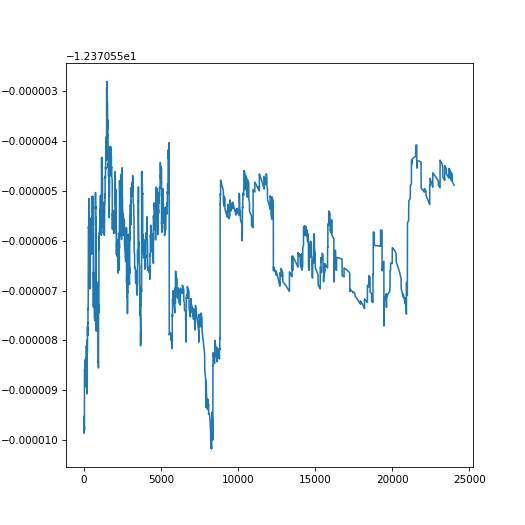

In [25]:
# Check convergence
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(signal_lls)

<IPython.core.display.Javascript object>


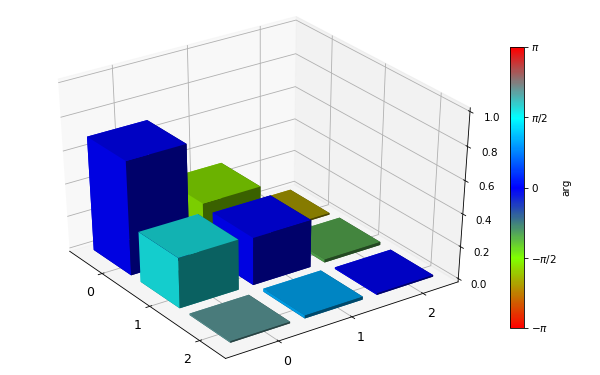

In [26]:
# Check to see if rho_00 = rho_11
lower_cutoff = 0
upper_cutoff = 2
windowed_reconstructed_signal_state = state_vis.windowed_density_matrix(reconstructed_signal_state,
                                                                        lower_cutoff,
                                                                        upper_cutoff)
fig, ax = state_vis.plot_density_matrix(windowed_reconstructed_signal_state)

Vaccuum mixin: (0.5971845023125946+0j)


<IPython.core.display.Javascript object>


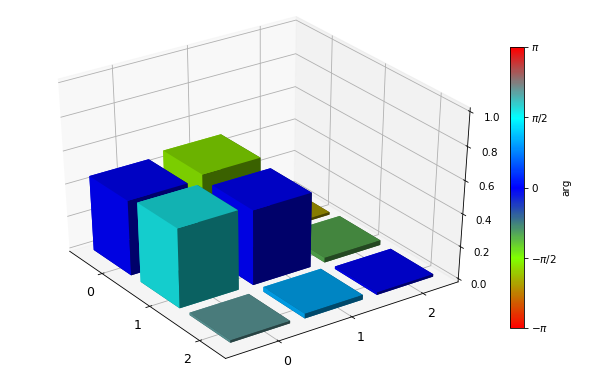

1.0000000000000009
(0.4900652969682108+0j)


In [27]:
# Correct for loss and plot
eta = 1 - (windowed_reconstructed_signal_state[0][0] - windowed_reconstructed_signal_state[1][1])
print('Vaccuum mixin: ' + str(eta))

vaccuum = qutip.basis(dim, 0) * qutip.basis(dim, 0).dag()
loss_corrected_reconstructed_state = (reconstructed_signal_state - (1 - eta)*vaccuum)
loss_corrected_reconstructed_state = loss_corrected_reconstructed_state / loss_corrected_reconstructed_state.tr()

lower_cutoff = 0
upper_cutoff = 2
windowed_loss_corrected_reconstructed_state = state_vis.windowed_density_matrix(loss_corrected_reconstructed_state,
                                                             lower_cutoff,
                                                             upper_cutoff)
fig, ax = state_vis.plot_density_matrix(windowed_loss_corrected_reconstructed_state)

print(loss_corrected_reconstructed_state.tr())
print(loss_corrected_reconstructed_state[0][0][0])

In [30]:
# SAVE POVM
povm_path = '/Users/andreas/Desktop/work/QuantumUtils/characterization_and_tomography/photonic_state_tomography/generated_data/povms/'
filename = 'dim_300_halfwidth_7p5_res_0p5_1p37_noise_photons.npz'
povm_savepath = os.path.join(povm_path, filename)
cst2.save_povm(povm_savepath, ideal_povm, alphas, xs, ps)

povms, new_alphas, new_xs, new_ps, new_noise_state = cst2.load_povm(povm_savepath)

In [40]:
# SAVE MLE RECONSTRUCTION
iter_path = "/Users/andreas/Desktop/work/QuantumUtils/characterization_and_tomography/photonic_state_tomography/generated_data/reconstruction_checkpoints/"
filename = '1p5_pi_half_reconstruction.npz'
iter_savepath = os.path.join(povm_path, filename)
iter_range = [12000, 36000]
rho0 = qutip.maximally_mixed_dm(dim)
cst2.save_reconstruction_iteration(iter_savepath,
                                   reconstructed_signal_state,
                                   hist_2D,
                                   signal_lls,
                                   alphas,
                                   xs,
                                   ps,
                                   iter_range,
                                   rho0,
                                   povm_savepath)

s, h, l, a, x, p, ir, r0, pp = cst2.load_reconstruction_iteration(iter_savepath)

<IPython.core.display.Javascript object>


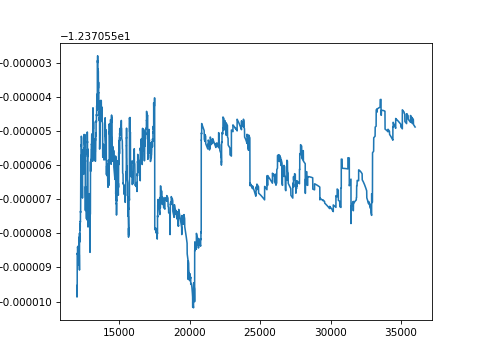

In [41]:
fig, ax = plt.subplots()
ax.plot(range(ir[0], ir[1]), l)

<IPython.core.display.Javascript object>


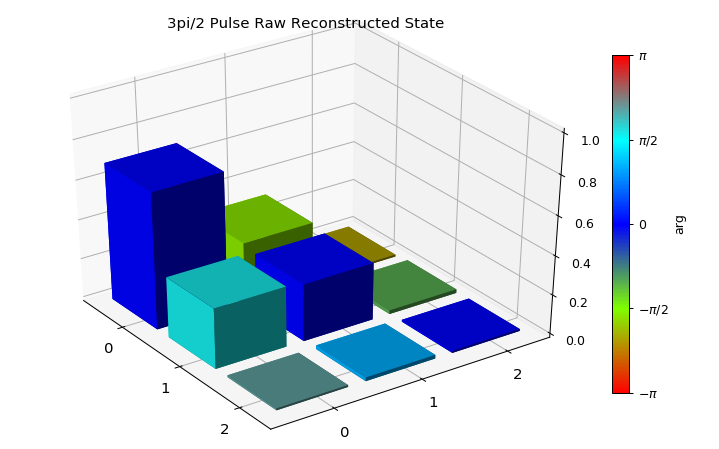

Text(0.5, 0.92, '3pi/2 Pulse Raw Reconstructed State')

In [135]:
# Verify save
lower_cutoff = 0
upper_cutoff = 2
windowed_reconstructed_signal_state = state_vis.windowed_density_matrix(reconstructed_signal_state,
                                                                        lower_cutoff,
                                                                        upper_cutoff)
fig, ax = state_vis.plot_density_matrix(windowed_reconstructed_signal_state)
ax.set_title('3pi/2 Pulse Raw Reconstructed State')

In [138]:
max_lost_photons = 1
eta = 0.5971845023125946
# eta = eta - 0.021

def inverse_bernoulli(rho, eta, max_lost_photons):
    dim = rho.shape[0]
    B_numbers = np.zeros((dim + max_lost_photons, dim + max_lost_photons))
    for i, _ in enumerate(B_numbers):
        for j, _ in enumerate(B_numbers[0]):
            B_numbers[i][j] = special.comb(i, j)
    
    inverted_rho = np.zeros(rho.shape, dtype=np.complex128)
    for k in range(max_lost_photons + 1):
        for m, _ in enumerate(inverted_rho):
            for n, _ in enumerate(inverted_rho[0]):
                if n + k < dim and m + k < dim:
                    eta_coeff = (eta)**(-(n + m)/2) * (1 - 1/eta)**k
                    B_coeff = B_numbers[m + k][m]**(1/2) * B_numbers[n + k][n]**(1/2)
                    inverted_rho[m][n] += rho[n + k][0][m + k] * eta_coeff * B_coeff
    
    return inverted_rho

ir = inverse_bernoulli(reconstructed_signal_state, eta, max_lost_photons)

<IPython.core.display.Javascript object>


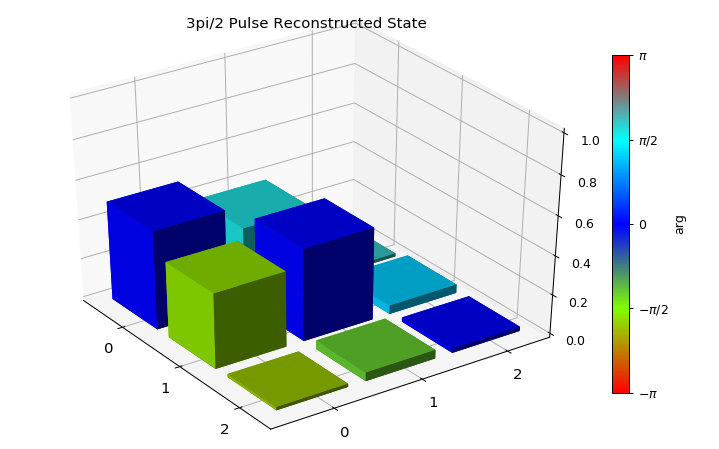

Text(0.5, 0.92, '3pi/2 Pulse Reconstructed State')

In [139]:
# Verify save
lower_cutoff = 0
upper_cutoff = 2
windowed_reconstructed_signal_state = state_vis.windowed_density_matrix(ir,
                                                                        lower_cutoff,
                                                                        upper_cutoff)
fig, ax = state_vis.plot_density_matrix(windowed_reconstructed_signal_state)
ax.set_title('3pi/2 Pulse Reconstructed State')

In [111]:
range(1)

range(0, 1)

In [172]:
# dim = 300
# max_x = 5
# mesh_size = 0.5
# efficiency = 0.75
# povm, _,_,_ = cst2.generate_coherent_state_POVM(max_x, mesh_size, dim)

s = time.time()
x = cst2.povm_element_bernoulli_transform(ideal_povm[0][0], efficiency, dim)
e = time.time()
print(s - e)

Time generating Bernoulli numbers: 1.848958969116211 s


KeyboardInterrupt: 

In [132]:
(200*(7.5/0.5*2 + 1)**2)/3600

53.388888888888886

In [169]:
x = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
print(x)
y = np.zeros(x.shape)
print(y[0:,0:])
print(x[:-1,:-1])
y[0:,0:] = x[:-0,:-0]
print(y)
z = np.stack([x, y])
print(z)


[[1 2 3]
 [4 5 6]
 [7 8 9]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[1 2]
 [4 5]]


ValueError: could not broadcast input array from shape (0,0) into shape (3,3)

In [174]:
dim = 300
B_kmn = cst2.generate_bernoulli_coefficient_tensor(efficiency, dim, dim)



In [175]:
s = time.time()
mod_povm = cst2.fast_povm_element_bernoulli_transform(ideal_povm[0][0], B_kmn, dim)
e = time.time()
print(e - s)


1.0029628276824951


In [158]:
print(B_kmn.shape)

(41, 80, 80)


In [188]:
eta = 0.04
x = np.matrix([[1, 0, 0, eta],[0, 1-eta, 0, 0],[0, 0, 0, 0],[eta, 0, 0, eta]])
print(x)

[[1.   0.   0.   0.04]
 [0.   0.96 0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.04 0.   0.   0.04]]


In [189]:
print(np.linalg.eigvals(x))

[1.00166378 0.03833622 0.96       0.        ]


In [190]:
print('hi')

hi
